# Conversion Rate

## 1.0 Importing Essential Libraries

In [1]:
# For mathematical computation 

import numpy as np 
import pandas as pd 
import scipy as sp 


# For building plots
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# Machine learning modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score

%config Completer.use_jedi = False

## 2.0 Import Dataset

In [2]:
# importing the dataset using pandas

conv_df = pd.read_csv("dataset/conversion_data.csv")

# Checking the first five elements of the dataset
conv_df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


## 3.0 Dataset Exploration and Cleaning

In [3]:
# number of customers and features in the dataset

# The dataset contains records for more than 31000 customers with 6 features

conv_df.shape

(316200, 6)

In [4]:
# Checking the dataset features and data types 

# We can see that we are dealing with integer and character features

conv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
# Checking explicitely for missing values across the features

# The dataset does not include any missing values as shown below

conv_df.isnull().sum()

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [6]:
# Checking the distibution of numeric features

# As shown below - some of the features have outlier values (expreme values toward boundries)

conv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,316200.0,30.569858,8.271802,17.0,24.0,30.0,36.0,123.0
new_user,316200.0,0.685465,0.464331,0.0,0.0,1.0,1.0,1.0
total_pages_visited,316200.0,4.872966,3.341104,1.0,2.0,4.0,7.0,29.0
converted,316200.0,0.032258,0.176685,0.0,0.0,0.0,0.0,1.0


### 3.1 Checking and Handling outliers

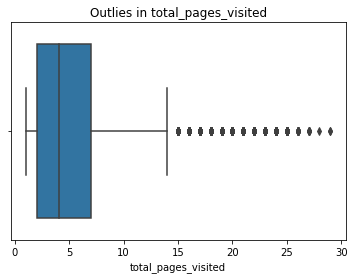

In [7]:
# The features , age and total_pages_visited, are seen to have outlies on their max values

# Let us examine outlies in the total_pages_visited variable 

sns.boxplot(x=conv_df['total_pages_visited']);
plt.title('Outlies in total_pages_visited')
plt.show()

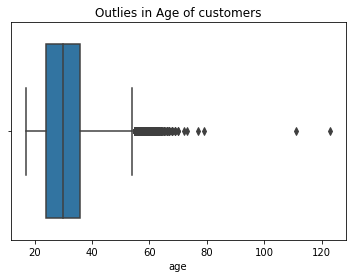

In [8]:
# Similarly, Let us examine outlies in the variable age

sns.boxplot(x=conv_df['age'])
plt.title("Outlies in Age of customers")
plt.show()

In [9]:
# Regarding age, having people older than 100 might not be helpful to out computation because it is not common

# Hence, dropping ages greater than 100 is reasonable

conv_df = conv_df[conv_df['age'] < 100]

        ** A data record is mathematically said to be outlier if 
                * It is 1.5 times Interquartile range greater than the 3rd quartile, or 
                * It is 1.5 times Interquartile range lower than the 1st quartile. 

        ** Moreover, a data record is said to be outlier if
                * It lies beyond 3rd standard deviation of particular feature


        ** Hence, we will remove the outliers in the section below using standard deviation

In [10]:
def min_outlier(data):


    outliers = list()
    """ data_mean : calculate the mean of the data
        data_std : calculate the standard deviation of the data
    """

    data_mean = np.mean(data)
    data_std = np.std(data)

    for record in data:
        z_score = (record - data_mean)/ data_std
    # An outlier if the data record lies beyond the 3rd standard deviation
        if np.abs(z_score) > 3: 
            outliers.append(record)
    return min(outliers)

In [11]:
total_pages_visited_min_outlier = min_outlier(conv_df['total_pages_visited'])
total_pages_visited_min_outlier

15

In [12]:
## Unique countries in the dataset
conv_df['country'].unique()

array(['UK', 'US', 'China', 'Germany'], dtype=object)

In [13]:
# Unique sources in the dataset
conv_df['source'].unique()

array(['Ads', 'Seo', 'Direct'], dtype=object)

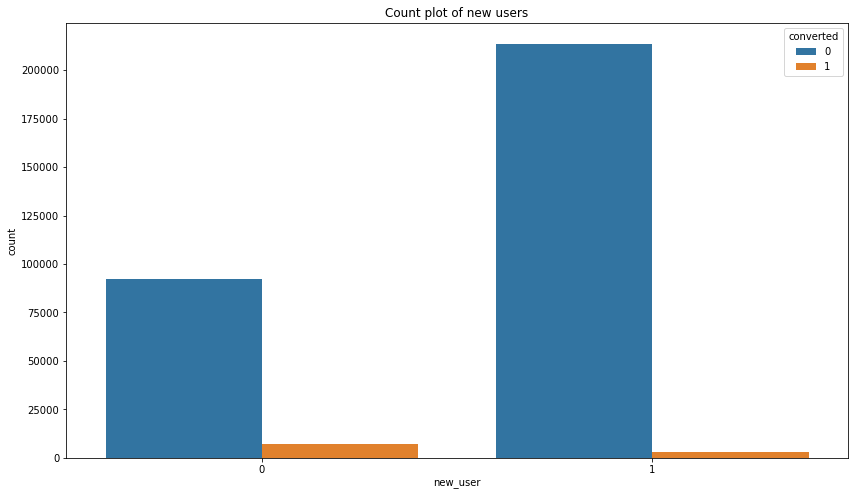

In [14]:
# Visualization of different new users agains conversion
plt.figure(figsize=(14,8))
sns.countplot(x='new_user', hue='converted', data=conv_df)
plt.title("Count plot of new users");

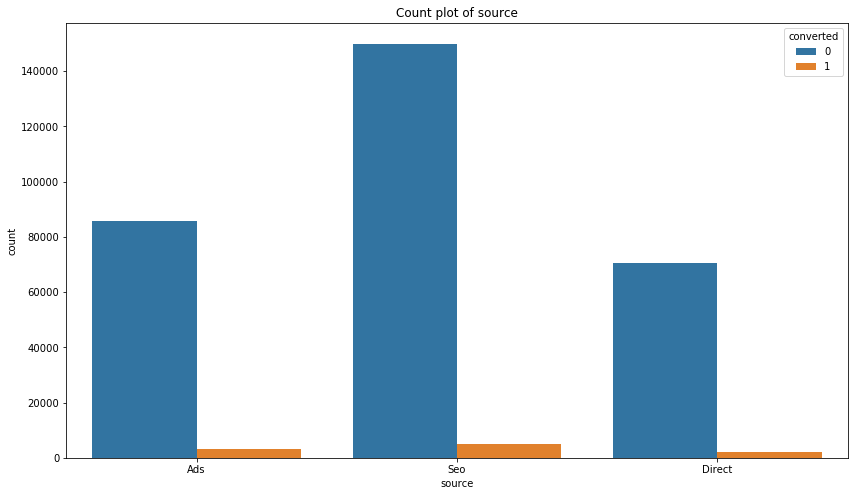

In [15]:
# Visualizing different sources against conversion

plt.figure(figsize=(14,8))
sns.countplot(x = 'source', hue='converted', data=conv_df)
plt.title("Count plot of source");

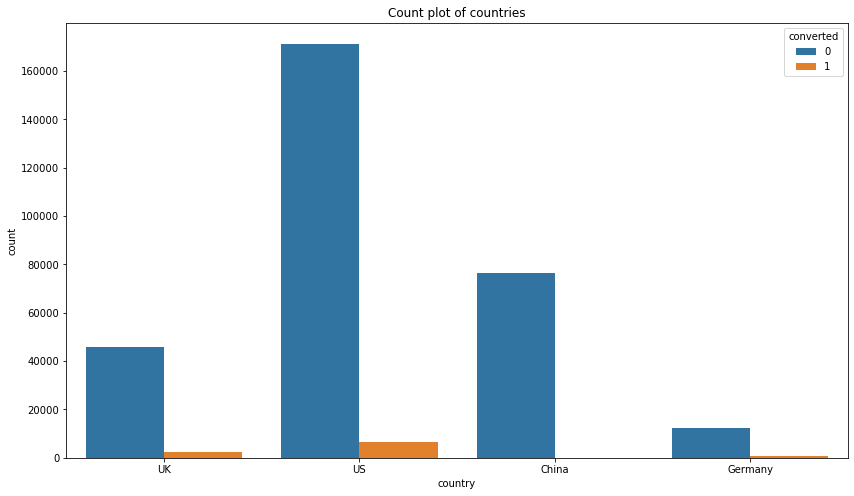

In [16]:

plt.figure(figsize=(14,8))
sns.countplot(x='country', hue='converted', data=conv_df)
plt.title('Count plot of countries');

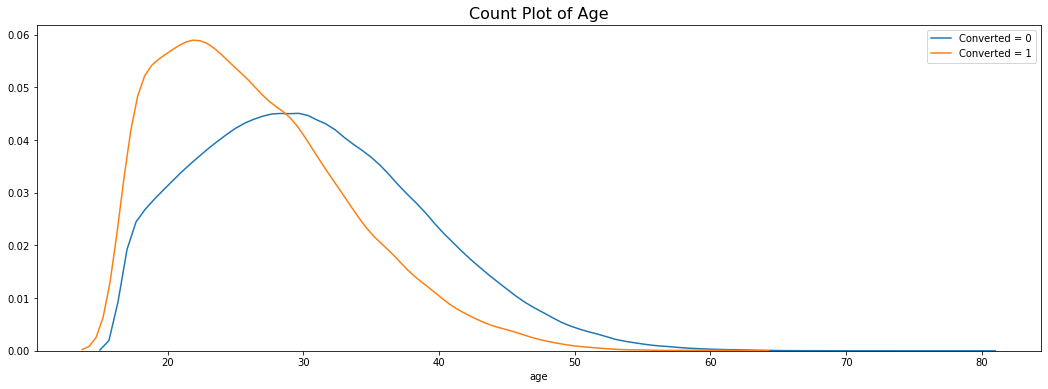

In [17]:
# Visualization of age against conversion rate

plt.figure(figsize=(18, 6))
sns.distplot(conv_df[conv_df['converted'] == 0]['age'], label='Converted = 0', hist=False)
sns.distplot(conv_df[conv_df['converted'] == 1]['age'], label='Converted = 1', hist=False)
plt.title('Count Plot of Age', fontsize=16)
plt.legend()
plt.show()

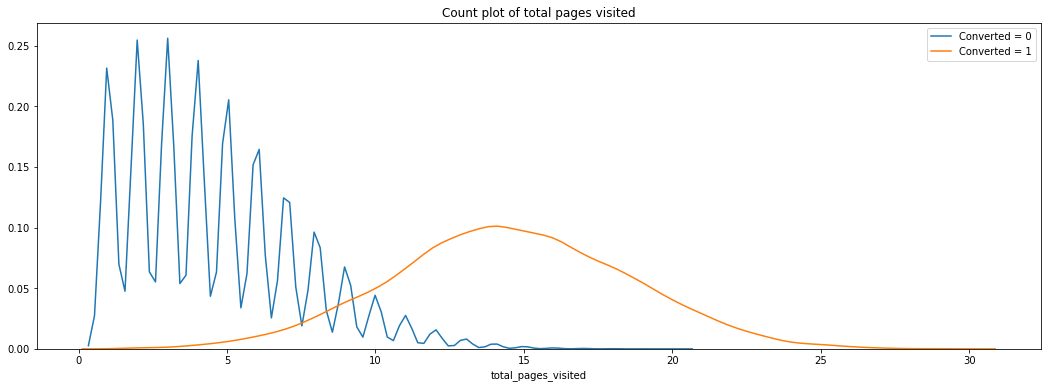

In [18]:
# Visualization of total pages visited against conversion

plt.figure(figsize=(18,6))
sns.distplot(conv_df[conv_df['converted']==0]['total_pages_visited'], label='Converted = 0', hist=False)
sns.distplot(conv_df[conv_df['converted']==1]['total_pages_visited'], label='Converted = 1', hist=False)
plt.title('Count plot of total pages visited')
plt.legend()
plt.show()

## 4.0 Preparing The Data for a Model

### 4.1 Converting categorical features to one-hot endcoding 

In [19]:
# In this section, all the categorical features will be represented by their one-hot encoding format

# country and source are the only categorical features 

# It is shown clearly below that 

conv_df = pd.get_dummies(conv_df)
conv_df.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


### 4.2 Splitting the data into training and test subsets

In [20]:
# Getting the label, converted feature, from the main dataset first

labels = conv_df['converted']

# Dropping labels from the dataset

conv_df.drop('converted', axis = 1, inplace=True)

In [21]:
# Chekcing features after dropping labels
conv_df.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1


In [22]:
# Splitting the dataset into train and test in the ratio of 80:20

X_train, X_test, y_train, y_test = train_test_split(conv_df, labels, test_size=0.2, random_state=42, shuffle=True, stratify=labels)

      * Checking label imbalances in train and testing subsets by checking the mean values of labels in both subsets

      * However, we can see that both have same mean value which tells that the split is not biased

In [23]:
print("Mean value of labels in training subset is {:.2}".format(y_train.mean()))
print("\nMean value of labels in the testing subset is {:.2}".format(y_test.mean()))

Mean value of labels in training subset is 0.032

Mean value of labels in the testing subset is 0.032


    * However, since, the labels are imbalanced, accuracy is not the best metric to use for this problem

## 5.0 Building Machine Learning Model



### 5.1 Support Vector Machine

In [24]:
# Defining Support Vector Classifier

svc = SVC()

# SVC hyperparameters
params = { 'kernel' : ['linear', 'rbf'], 'C': [0.01, 0.1]}

cv = GridSearchCV(svc, params, cv=5, scoring='f1_macro')

cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1], 'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1_macro', verbose=0)

In [26]:
# Printing the results using the function above

from print_results import print_results
print_results(cv)

Best Params: {'C': 0.1, 'kernel': 'linear'}

0.874 (+/-0.009) for {'C': 0.01, 'kernel': 'linear'}
0.793 (+/-0.009) for {'C': 0.01, 'kernel': 'rbf'}
0.875 (+/-0.008) for {'C': 0.1, 'kernel': 'linear'}
0.847 (+/-0.005) for {'C': 0.1, 'kernel': 'rbf'}


In [27]:
# Prediction
test_prediction = cv.predict(X_test)

In [29]:
# The best f1_score for support vector machine

# The model has reasonable decent performance on the data

print("f1_score for Testing Dataset = ", f1_score(y_test, test_prediction, average='macro'))

f1_score for Testing Dataset =  0.8775192014579443


In [43]:
# Classification Report
print(classification_report(y_test, test_prediction))

precision    recall  f1-score   support

           0       0.99      1.00      0.99     61200
           1       0.86      0.68      0.76      2040

    accuracy                           0.99     63240
   macro avg       0.92      0.84      0.88     63240
weighted avg       0.99      0.99      0.99     63240



In [44]:
# Confusion matrix of classification by SVC

confusion_mtx = confusion_matrix(y_test, test_prediction)

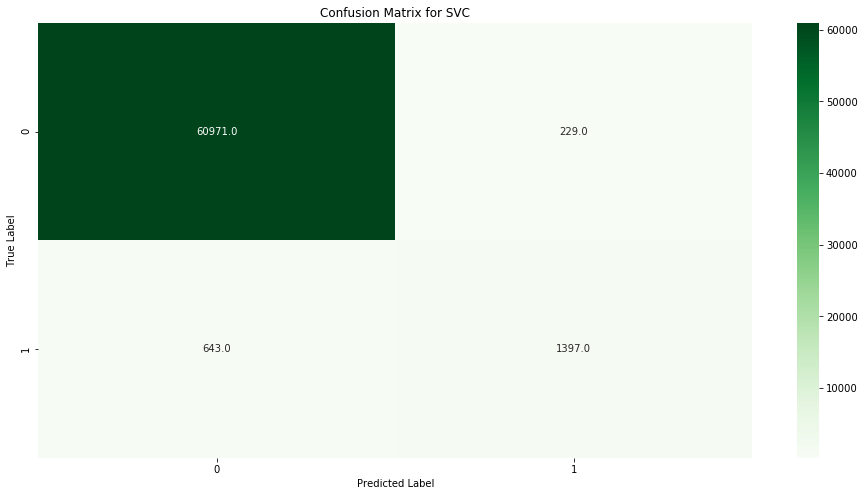

In [45]:
# Plotting confusion matrix

plt.figure(figsize=(16,8))
sns.heatmap(confusion_mtx, annot=True, cmap='Greens', linecolor='gray', fmt='.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for SVC")
plt.show()

## 5.2 Random Forest Classifier 

In [32]:
# Defining random forest classifier

rf = RandomForestClassifier()

params = {
    'n_estimators': [100, 200],
    'max_depth': [32, None],
    'max_features': [2, 5]
}

cv = GridSearchCV(rf, params, cv=5, scoring='f1_macro')

cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [33]:
# Checking the performance of the model on combinations of different parameters
print_results(cv)

Best Params: {'max_depth': None, 'max_features': 5, 'n_estimators': 100}

0.866 (+/-0.007) for {'max_depth': 32, 'max_features': 2, 'n_estimators': 100}
0.865 (+/-0.007) for {'max_depth': 32, 'max_features': 2, 'n_estimators': 200}
0.865 (+/-0.007) for {'max_depth': 32, 'max_features': 5, 'n_estimators': 100}
0.865 (+/-0.008) for {'max_depth': 32, 'max_features': 5, 'n_estimators': 200}
0.865 (+/-0.007) for {'max_depth': None, 'max_features': 2, 'n_estimators': 100}
0.866 (+/-0.006) for {'max_depth': None, 'max_features': 2, 'n_estimators': 200}
0.866 (+/-0.008) for {'max_depth': None, 'max_features': 5, 'n_estimators': 100}
0.866 (+/-0.008) for {'max_depth': None, 'max_features': 5, 'n_estimators': 200}


In [34]:
# Prediction
test_pred = cv.predict(X_test)

In [37]:
# Printing the best f1_score
print("The best f1_score achieved by Random Forest Classifier: ", f1_score(y_test, test_pred, average='macro'))

The best f1_score achieved by Random Forest Classifier:  0.8610199526378637


      * Random Forest has slightly lower performance than Support Vector Machine 

In [38]:
# Classification report 
print(classification_report(test_pred, y_test))

precision    recall  f1-score   support

           0       0.99      0.99      0.99     61547
           1       0.67      0.81      0.73      1693

    accuracy                           0.98     63240
   macro avg       0.83      0.90      0.86     63240
weighted avg       0.99      0.98      0.98     63240



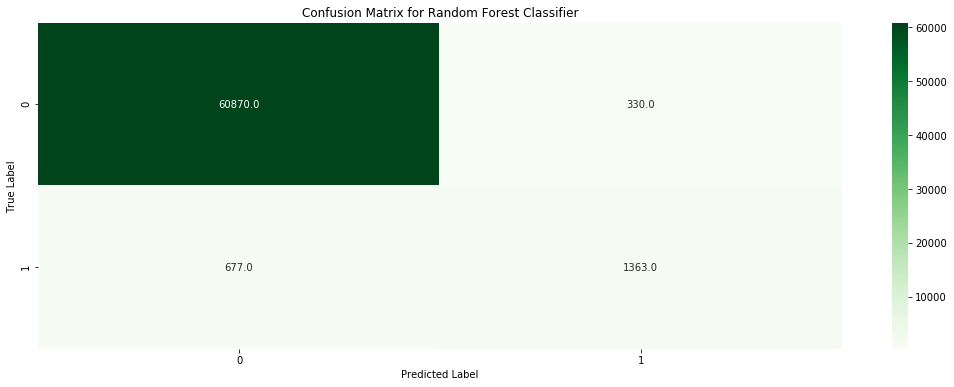

In [46]:
# Confusion Matrix for Random Forest Classifier

con_mtx = confusion_matrix(y_test, test_pred)

plt.figure(figsize=(18,6))
sns.heatmap(con_mtx, annot=True, cmap='Greens', linecolor='gray', fmt='.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()